In [ ]:
from tensorflow.keras.applications import EfficientNetB1
model = EfficientNetB1(weights='imagenet', drop_connect_rate=0.4)


32153600/32148312 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

model = InceptionV3(weights = "imagenet", include_top=False)

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
IMG_SIZE = 240
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
    print("Running on TPU ", tpu.cluster_spec().as_dict()["worker"])
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    strategy = tf.distribute.MirroredStrategy()

Not connected to a TPU runtime. Using CPU/GPU strategy
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [ ]:
import tensorflow_datasets as tfds

batch_size = 64

dataset_name = "food101"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "validation"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteNZAND3/food101-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/food101/2.0.0.incompleteNZAND3/food101-validation.tfrecord


Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

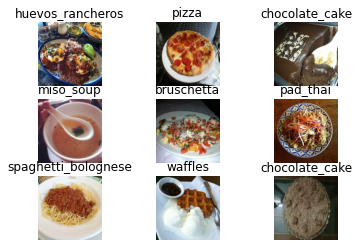

In [ ]:
import matplotlib.pyplot as plt


def format_label(label):
    string_label = label_info.int2str(label)
    return string_label.split("-")[0]


label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

img_augmentation = Sequential(
    [
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

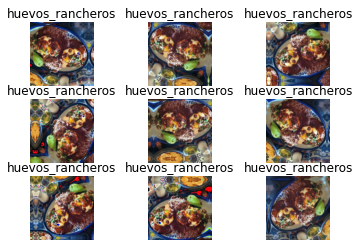

In [ ]:
for image, label in ds_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image, axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(format_label(label)))
        plt.axis("off")

In [ ]:
# One-hot / categorical encoding
def input_preprocess(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


ds_train = ds_train.map(
    input_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE
)
ds_train = ds_train.batch(batch_size=batch_size, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.experimental.AUTOTUNE)

ds_test = ds_test.map(input_preprocess)
ds_test = ds_test.batch(batch_size=batch_size, drop_remainder=True)

In [ ]:
from tensorflow.keras.applications import EfficientNetB1

with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = EfficientNetB1(include_top=True, weights=None, classes=NUM_CLASSES)(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 50  
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        [(None, 240, 240, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 240, 240, 3)       0         
_________________________________________________________________
efficientnetb1 (Functional)  (None, 101)               6704620   
Total params: 6,704,620
Trainable params: 6,642,565
Non-trainable params: 62,055
_________________________________________________________________
Epoch 1/50
1183/1183 - 563s - loss: 4.4047 - accuracy: 0.0386 - val_loss: 3.9917 - val_accuracy: 0.0879
Epoch 2/50
1183/1183 - 542s - loss: 3.8134 - accuracy: 0.1144 - val_loss: 3.5411 - val_accuracy: 0.1597
Epoch 3/50
1183/1183 - 544s - loss: 3.4058 - accuracy: 0.1870 - val_loss: 3.5083 - val_accuracy: 0.2169
Epoch 4/50
1183/1183 - 546s - loss: 3.0588 - accuracy: 0.2548

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
with strategy.scope():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    x = img_augmentation(inputs)
    outputs = InceptionV3(include_top=True, weights=None, classes=NUM_CLASSES, input_tensor=Input(shape=(100, 100, 3)))(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )

model.summary()

epochs = 32  
hist = model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 240, 240, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 240, 240, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 101)               22009733  
Total params: 22,009,733
Trainable params: 21,975,301
Non-trainable params: 34,432
_________________________________________________________________
Epoch 1/32
INFO:tensorflow:Error reported to Coordinator: Input 0 is incompatible with layer inception_v3: expected shape=(None, 299, 299, 3), found shape=(64, 240, 240, 3)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/coordinator.py", line 297, in stop_on_exception
    yield
  File "/usr/local/lib/python3.7/d

INFO:tensorflow:Error reported to Coordinator: Input 0 is incompatible with layer inception_v3: expected shape=(None, 299, 299, 3), found shape=(64, 240, 240, 3)
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/training/coordinator.py", line 297, in stop_on_exception
    yield
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/distribute/mirrored_run.py", line 334, in run
    self.main_result = self.main_fn(*self.main_args, **self.main_kwargs)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py", line 692, in wrapper
    return converted_call(f, args, kwargs, options=options)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py", line 382, in converted_call
    return _call_unconverted(f, args, kwargs, options)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/autograph/impl/api.py", line 463, in _call_unconverted
    return f(*args, **kwa

ValueError: ignored

In [ ]:
model.save('saved_model/a_model') 

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from tensorflow import keras
import numpy as np
sunflower_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRfsjbjfw2Md7sl1JbTR5kGMxcrRlD6Bm7cfQ&usqp=CAU"
sunflower_path = tf.keras.utils.get_file('16', origin=sunflower_url)
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

model = tf.keras.models.load_model('saved_model/first_model')

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
inds = np.argpartition(score, -5)[-5:]
#print(inds)




#print(score)
class_names = ds_info.features["label"].names
for i in range(len(inds)):  
  print(f"Class: {class_names[inds[i]]}   score: {score[inds[i]]}")

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

Class: beef_carpaccio   score: 0.009973506443202496
Class: bruschetta   score: 0.010130226612091064
Class: omelette   score: 0.010455192066729069
Class: hummus   score: 0.010542301461100578
Class: pizza   score: 0.019841764122247696
This image most likely belongs to pizza with a 1.98 percent confidence.


In [ ]:
!mkdir -p saved_model
model.save('saved_model/first_model') 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: saved_model/first_model/assets


INFO:tensorflow:Assets written to: saved_model/first_model/assets


In [ ]:
new_model = tf.keras.models.load_model('saved_model/first_model')

# Check its architecture
new_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, 101)               4178952   
Total params: 4,178,952
Trainable params: 4,136,929
Non-trainable params: 42,023
_________________________________________________________________


In [ ]:
epochs = 10  
hist = new_model.fit(ds_train, epochs=epochs, validation_data=ds_test, verbose=2)

Epoch 1/10
1183/1183 - 359s - loss: 0.7627 - accuracy: 0.7759 - val_loss: 1.6360 - val_accuracy: 0.6198
Epoch 2/10
1183/1183 - 351s - loss: 0.7176 - accuracy: 0.7879 - val_loss: 1.6301 - val_accuracy: 0.6269
Epoch 3/10
1183/1183 - 351s - loss: 0.6845 - accuracy: 0.7947 - val_loss: 1.7638 - val_accuracy: 0.6096
Epoch 4/10
1183/1183 - 350s - loss: 0.6426 - accuracy: 0.8071 - val_loss: 1.6323 - val_accuracy: 0.6306
Epoch 5/10
1183/1183 - 350s - loss: 0.6018 - accuracy: 0.8172 - val_loss: 1.8358 - val_accuracy: 0.6085
Epoch 6/10
1183/1183 - 350s - loss: 0.5810 - accuracy: 0.8217 - val_loss: 1.7281 - val_accuracy: 0.6273
Epoch 7/10
1183/1183 - 350s - loss: 0.5404 - accuracy: 0.8332 - val_loss: 1.8470 - val_accuracy: 0.6186
Epoch 8/10
1183/1183 - 350s - loss: 0.5137 - accuracy: 0.8391 - val_loss: 1.8508 - val_accuracy: 0.6215
Epoch 9/10
1183/1183 - 350s - loss: 0.4939 - accuracy: 0.8461 - val_loss: 1.9076 - val_accuracy: 0.6157
Epoch 10/10
1183/1183 - 333s - loss: 0.4679 - accuracy: 0.8521 -

In [ ]:
import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input
def train_model(n_classes,num_epochs):
    inception = InceptionV3(weights='imagenet', include_top=False)
    x = inception.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128,activation='relu')(x)
    x = Dropout(0.2)(x)
    bestmodel_path = "saved_model/best_model"
    trainedmodel_path = "saved_model/trained_model"
    history_path = "saved_model/history_"+str(n_classes)+".log"
    predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

    model = Model(inputs=inception.input, outputs=predictions)
    model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
    checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
    csv_logger = CSVLogger(history_path)
    history = model.fit(ds_train,
                        batch_size = 40,
                        validation_data=ds_test,
                        epochs=num_epochs,
                        verbose=1,
                        callbacks=[csv_logger, checkpoint])
    model.save(trainedmodel_path)
    class_map = train_generator.class_indices
    return history, class_map

In [ ]:
epochs = 32  # @param {type: "slider", min:10, max:100}

history, class_map_3 = train_model(NUM_CLASSES, epochs)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/32
1183/1183 [==============================] - 393s 312ms/step - loss: 5.1556 - accuracy: 0.0225 - val_loss: 5.0269 - val_accuracy: 0.0520

Epoch 00001: val_loss improved from inf to 5.02688, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 2/32
1183/1183 [==============================] - 368s 311ms/step - loss: 4.8847 - accuracy: 0.0826 - val_loss: 4.6202 - val_accuracy: 0.1618

Epoch 00002: val_loss improved from 5.02688 to 4.62021, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 3/32
1183/1183 [==============================] - 365s 309ms/step - loss: 4.4576 - accuracy: 0.1758 - val_loss: 4.0956 - val_accuracy: 0.2818

Epoch 00003: val_loss improved from 4.62021 to 4.09557, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 4/32
1183/1183 [==============================] - 376s 317ms/step - loss: 4.0195 - accuracy: 0.2584 - val_loss: 3.6060 - val_accuracy: 0.3765

Epoch 00004: val_loss improved from 4.09557 to 3.60605, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 5/32
1183/1183 [==============================] - 366s 309ms/step - loss: 3.6143 - accuracy: 0.3324 - val_loss: 3.1703 - val_accuracy: 0.4452

Epoch 00005: val_loss improved from 3.60605 to 3.17033, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 6/32
1183/1183 [==============================] - 365s 309ms/step - loss: 3.2603 - accuracy: 0.3915 - val_loss: 2.8243 - val_accuracy: 0.4967

Epoch 00006: val_loss improved from 3.17033 to 2.82432, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 7/32
1183/1183 [==============================] - 376s 318ms/step - loss: 2.9721 - accuracy: 0.4431 - val_loss: 2.5634 - val_accuracy: 0.5415

Epoch 00007: val_loss improved from 2.82432 to 2.56344, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 8/32
1183/1183 [==============================] - 367s 310ms/step - loss: 2.7388 - accuracy: 0.4868 - val_loss: 2.3636 - val_accuracy: 0.5739

Epoch 00008: val_loss improved from 2.56344 to 2.36359, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 9/32
1183/1183 [==============================] - 368s 311ms/step - loss: 2.5480 - accuracy: 0.5239 - val_loss: 2.2127 - val_accuracy: 0.5966

Epoch 00009: val_loss improved from 2.36359 to 2.21269, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 10/32
1183/1183 [==============================] - 367s 310ms/step - loss: 2.3781 - accuracy: 0.5560 - val_loss: 2.0933 - val_accuracy: 0.6159

Epoch 00010: val_loss improved from 2.21269 to 2.09331, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 11/32
1183/1183 [==============================] - 368s 311ms/step - loss: 2.2375 - accuracy: 0.5840 - val_loss: 1.9980 - val_accuracy: 0.6309

Epoch 00011: val_loss improved from 2.09331 to 1.99805, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 12/32
1183/1183 [==============================] - 368s 311ms/step - loss: 2.1148 - accuracy: 0.6102 - val_loss: 1.9224 - val_accuracy: 0.6448

Epoch 00012: val_loss improved from 1.99805 to 1.92243, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 13/32
1183/1183 [==============================] - 367s 310ms/step - loss: 2.0024 - accuracy: 0.6330 - val_loss: 1.8588 - val_accuracy: 0.6557

Epoch 00013: val_loss improved from 1.92243 to 1.85877, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 14/32
1183/1183 [==============================] - 377s 319ms/step - loss: 1.9015 - accuracy: 0.6560 - val_loss: 1.8062 - val_accuracy: 0.6643

Epoch 00014: val_loss improved from 1.85877 to 1.80624, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 15/32
1183/1183 [==============================] - 377s 319ms/step - loss: 1.8027 - accuracy: 0.6779 - val_loss: 1.7634 - val_accuracy: 0.6698

Epoch 00015: val_loss improved from 1.80624 to 1.76343, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 16/32
1183/1183 [==============================] - 368s 311ms/step - loss: 1.7172 - accuracy: 0.6968 - val_loss: 1.7276 - val_accuracy: 0.6754

Epoch 00016: val_loss improved from 1.76343 to 1.72762, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 17/32
1183/1183 [==============================] - 368s 311ms/step - loss: 1.6337 - accuracy: 0.7152 - val_loss: 1.6959 - val_accuracy: 0.6817

Epoch 00017: val_loss improved from 1.72762 to 1.69594, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 18/32
1183/1183 [==============================] - 368s 311ms/step - loss: 1.5534 - accuracy: 0.7355 - val_loss: 1.6685 - val_accuracy: 0.6848

Epoch 00018: val_loss improved from 1.69594 to 1.66854, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 19/32
1183/1183 [==============================] - 368s 311ms/step - loss: 1.4810 - accuracy: 0.7524 - val_loss: 1.6477 - val_accuracy: 0.6879

Epoch 00019: val_loss improved from 1.66854 to 1.64772, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 20/32
1183/1183 [==============================] - 367s 310ms/step - loss: 1.4105 - accuracy: 0.7686 - val_loss: 1.6283 - val_accuracy: 0.6912

Epoch 00020: val_loss improved from 1.64772 to 1.62825, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 21/32
1183/1183 [==============================] - 377s 319ms/step - loss: 1.3431 - accuracy: 0.7843 - val_loss: 1.6116 - val_accuracy: 0.6944

Epoch 00021: val_loss improved from 1.62825 to 1.61165, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 22/32
1183/1183 [==============================] - 368s 311ms/step - loss: 1.2777 - accuracy: 0.8007 - val_loss: 1.5978 - val_accuracy: 0.6962

Epoch 00022: val_loss improved from 1.61165 to 1.59777, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 23/32
1183/1183 [==============================] - 368s 311ms/step - loss: 1.2168 - accuracy: 0.8158 - val_loss: 1.5870 - val_accuracy: 0.6983

Epoch 00023: val_loss improved from 1.59777 to 1.58698, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 24/32
1183/1183 [==============================] - 378s 320ms/step - loss: 1.1585 - accuracy: 0.8304 - val_loss: 1.5785 - val_accuracy: 0.7001

Epoch 00024: val_loss improved from 1.58698 to 1.57846, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 25/32
1183/1183 [==============================] - 378s 319ms/step - loss: 1.1048 - accuracy: 0.8430 - val_loss: 1.5710 - val_accuracy: 0.7019

Epoch 00025: val_loss improved from 1.57846 to 1.57104, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 26/32
1183/1183 [==============================] - 368s 311ms/step - loss: 1.0515 - accuracy: 0.8566 - val_loss: 1.5657 - val_accuracy: 0.7024

Epoch 00026: val_loss improved from 1.57104 to 1.56573, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 27/32
1183/1183 [==============================] - 378s 319ms/step - loss: 1.0014 - accuracy: 0.8698 - val_loss: 1.5616 - val_accuracy: 0.7023

Epoch 00027: val_loss improved from 1.56573 to 1.56160, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 28/32
1183/1183 [==============================] - 368s 311ms/step - loss: 0.9542 - accuracy: 0.8826 - val_loss: 1.5582 - val_accuracy: 0.7025

Epoch 00028: val_loss improved from 1.56160 to 1.55821, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 29/32
1183/1183 [==============================] - 367s 310ms/step - loss: 0.9089 - accuracy: 0.8931 - val_loss: 1.5571 - val_accuracy: 0.7017

Epoch 00029: val_loss improved from 1.55821 to 1.55714, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 30/32
1183/1183 [==============================] - 368s 311ms/step - loss: 0.8671 - accuracy: 0.9042 - val_loss: 1.5545 - val_accuracy: 0.7030

Epoch 00030: val_loss improved from 1.55714 to 1.55450, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 31/32
1183/1183 [==============================] - 378s 319ms/step - loss: 0.8309 - accuracy: 0.9140 - val_loss: 1.5541 - val_accuracy: 0.7030

Epoch 00031: val_loss improved from 1.55450 to 1.55414, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


Epoch 32/32
1183/1183 [==============================] - 367s 311ms/step - loss: 0.7926 - accuracy: 0.9214 - val_loss: 1.5538 - val_accuracy: 0.7028

Epoch 00032: val_loss improved from 1.55414 to 1.55381, saving model to saved_model/best_model
INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/best_model/assets


INFO:tensorflow:Assets written to: saved_model/trained_model/assets


INFO:tensorflow:Assets written to: saved_model/trained_model/assets


NameError: ignored

In [ ]:
!mkdir -p saved_model

In [ ]:
from tensorflow import keras
import numpy as np
sunflower_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRfsjbjfw2Md7sl1JbTR5kGMxcrRlD6Bm7cfQ&usqp=CAU"
sunflower_path = tf.keras.utils.get_file('17', origin=sunflower_url)
img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

model = tf.keras.models.load_model('saved_model/best_model')

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
inds = np.argpartition(score, -5)[-5:]
#print(inds)




#print(score)
class_names = ds_info.features["label"].names
for i in range(len(inds)):  
  print(f"Class: {class_names[inds[i]]}   score: {score[inds[i]]}")

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

16384/14141 [==================================] - 0s 0us/step
Class: pizza   score: 0.010147877968847752
Class: samosa   score: 0.010268308222293854
Class: huevos_rancheros   score: 0.010286950506269932
Class: omelette   score: 0.015207693912088871
Class: nachos   score: 0.010648204945027828
This image most likely belongs to omelette with a 1.52 percent confidence.
